In [7]:
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=20)
import matplotlib.pyplot as plt

import kwant
import numpy as np

sin30, cos30 = (1/2, np.sqrt(3)/2)

# Graphene nanoribbon

First we build a nanoribbon supercell to make it all easier to visualize.

We start with the honeycomb lattice from Kwant, and build the supercell from it.

In the first lines you can choose between **zigzag** or **armchair** and the size in term of the number of sites. Everything else is automatic here.

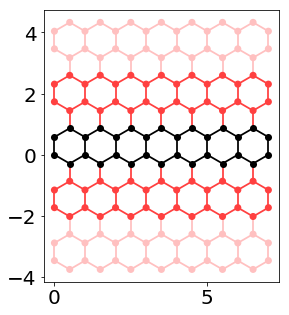

Supercell size = 15 : 4


In [55]:
# choose ribbon type and size
#ribbon = "zigzag"; Nz = 26;
ribbon = "armchair"; Na = 15;

# first/second neighbors hopping
t1 = 1.0
t2 = 0 #0.07/2.74
e0 = 0 #0.21/2.74

# the rest is automatic
if ribbon == "zigzag":
    Na = 2; # required for correct periodicity
if ribbon == "armchair":
    Nz = 4; # required for correct periodicity

a =1.0/np.sqrt(3) # distance between sites (a-b)
W0 = (Na-1)*np.sqrt(3)*a/2.0
L0 = (3*Nz-4)*(a)/4

az = np.array([np.sqrt(3)*a, 0]) # primitive vector for zigzag
aa = np.array([0, 3*a]) # primitive vector for zigzag

def quadrado(pos):
    (x,y) = pos
    return (-0.5 <= y <= (L0+0.1)) and (0 <= x <= (W0+0.1))

# 1) auxiliary system to capture the site positions
lat = kwant.lattice.honeycomb()
aux = kwant.Builder()
aux[lat.shape(quadrado, (0,0))] = 0
aux = aux.finalized()

# 2) basis for the supercell
base = np.array([], dtype=float)
for site in aux.sites:
    base = np.append(base, site.pos)
base = base.reshape(int(len(base)/2),2)

# 3) supercell
if ribbon == "armchair":
    latSC = kwant.lattice.general([aa], base)
if ribbon == "zigzag":
    latSC = kwant.lattice.general([az], base)

scell = kwant.Builder()
scell[latSC.shape(quadrado, (0,0))] = e0
scell[latSC.neighbors(1)] = t1
if t2 != 0: scell[latSC.neighbors(2)] = t2

# 4) leads
lead0 = kwant.Builder(kwant.TranslationalSymmetry(latSC.vec((1,))))
lead0[latSC.shape(quadrado, (0,0))] = e0
lead0[latSC.neighbors(1)] = t1
if t2 != 0: lead0[latSC.neighbors(2)] = t2

# 5) attach leads and finish the system
scell.attach_lead(lead0)
scell.attach_lead(lead0.reversed())

#del scell[latSC.sublattices[1](0)]
#scell.eradicate_dangling()

kwant.plot(scell, fig_size=(5,5), site_color='black', site_size=0.2);
scell = scell.finalized()

# count number of sites to check if correct
# it will also be used to plot the densities bellow

listX = []
listY = []
for i in range(len(scell.sites)):
    posX = int(1000*scell.sites[i].pos[0])
    posY = int(1000*scell.sites[i].pos[1])
    listX.append(posX)
    listY.append(posY)
listX = np.sort(np.unique(np.array(listX)))
listY = np.sort(np.unique(np.array(listY)))
print("Supercell size =", len(listX), ":", len(listY))

# Band structure

Calculates the bandstructure of the lead.

The k axis is given in units of the reciprocal vector, thus $-\frac{1}{2} < k < \frac{1}{2}$.

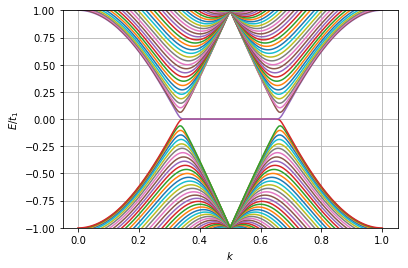

In [3]:
# leads band structure
if ribbon == "zigzag":
    momenta = np.linspace(0, 2*np.pi, 201)
    arqname = "tb-zigzag-bands-"+str(Nz)+".dat"
    
if ribbon == "armchair":
    momenta = np.linspace(-np.pi, np.pi, 201)
    arqname = "tb-armchair-bands-"+str(Na)+".dat"

plead = lead0.finalized();
bands = kwant.physics.Bands(plead)
energies = np.array([bands(k) for k in momenta])
plt.plot(momenta/(2*np.pi), energies);
plt.ylim([-1,1]);
#plt.xlim([0, 1])
plt.xlabel("$k$")
plt.ylabel("$E/t_1$")
plt.grid()
plt.show()

np.savetxt(arqname, energies)

# Density

Projected along the confinement direction

In [25]:
# plot all densities

# 96
#wf = kwant.wave_function(scell, energy=0.0025/2.4) # for n=0
#wf = kwant.wave_function(scell, energy=0.33/2.4) # for n=1

# 148
#wf = kwant.wave_function(scell, energy=0.0025/2.4) # for n=0
wf = kwant.wave_function(scell, energy=0.15/2.4) # for n=1
wf0 = wf(0)
print("Nocc=", len(wf0))

Nocc= 3


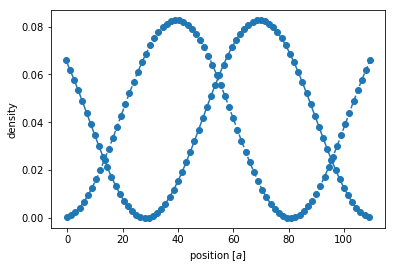

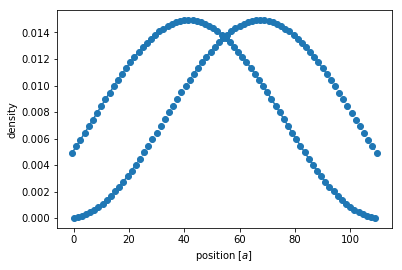

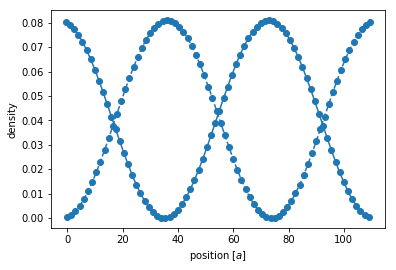

In [26]:
# plot on 2D map
#for i in range(len(wf0)):
    #density = np.abs(wf0[i])**2
    #kwant.plotter.density(scell, density, colorbar=False);

# project denisty on a single coordinate
if ribbon == "zigzag":
    lista = listY
    arqname = "tb-zigzag-dens-"+str(Nz)+".dat"
    posi = 1
if ribbon == "armchair":
    lista = listX
    posi = 0
    
for n in range(len(wf0)):
    density = np.abs(wf0[n])**2
    projdens = np.zeros(len(lista))
    for i in range(len(scell.sites)):
        pos = int(1000*scell.sites[i].pos[posi])
        ind = np.where(lista==pos)
        projdens[ind] += density[i]
    plt.figure() # uncomment to split figures in different panels
    if ribbon == "armchair": # densA=densB
        plt.plot(lista/1000/a, projdens, 'o-');
        arqname = "tb-armchair-dens-"+str(Na)+"-"+str(n)+".dat"
        np.savetxt(arqname, np.array([lista/1000/a, projdens]).T)
        
    if ribbon == "zigzag": # A with solid lines, B with dashed lines
        p = plt.plot(listY[::2]/1000/a, projdens[::2], 'o-');
        plt.plot(listY[1::2]/1000/a, projdens[1::2], 'o--', color=p[0].get_color());
        arqname = "tb-zigzag-dens-"+str(Nz)+"-"+str(n)+".dat"
        np.savetxt(arqname, np.array([listY/1000/a, projdens]).T)
        
        
    plt.xlabel("position [$a$]")
    plt.ylabel("density")

# Conductance

In [6]:
energies = np.linspace(-3.5, 3.5, 200)
data = np.array([], dtype=float)
for en in energies:
    smatrix = kwant.smatrix(scell, en)
    data = np.append(data, smatrix.transmission(1, 0))

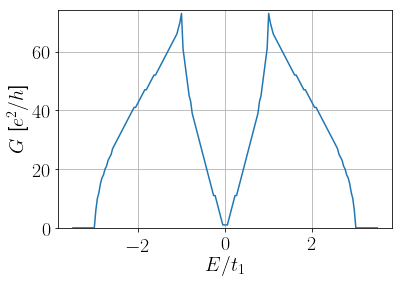

In [112]:
plt.plot(energies, data)
plt.xlabel("$E/t_1$")
plt.ylabel("$G$ [$e^2/h$]")
plt.ylim([0, np.ceil(np.max(data))])
plt.grid();